In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.linear_model import LinearRegression
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [2]:
companies = ["enexis", "liander", "stedin"]
years = ["2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018"]
energy_type = ["electricity", "gas"]

In [3]:
total_data_electricity = pd.DataFrame()
total_data_gas = pd.DataFrame()
for e_type in energy_type:
    for company in companies:
        for year in years:
            file_path = "%s/%s_%s_%s.csv" % (e_type, company, e_type, year)
            data = pd.read_csv(file_path)
            data["date"] = year
            if(e_type == "electricity"):
                total_data_electricity = total_data_electricity.append(data)
            else:
                total_data_gas = total_data_gas.append(data)

In [4]:
total_data_electricity.head()

,annual_consume,annual_consume_lowtarif_perc,city,date,delivery_perc,net_manager,num_connections,perc_of_active_connections,purchase_area,smartmeter_perc,street,type_conn_perc,type_of_connection,zipcode_from,zipcode_to
0,4282.0,25.0,WERKENDAM,2010,100.0,Enexis B.V.,16,100.0,ENEXIS,0.0,Sasdijk,NaN,NaN,4251AB,4251AB
1,5113.0,10.0,WERKENDAM,2010,100.0,Enexis B.V.,11,100.0,ENEXIS,0.0,Sasdijk,NaN,NaN,4251AC,4251AC
2,4809.0,34.0,WERKENDAM,2010,100.0,Enexis B.V.,30,100.0,ENEXIS,0.0,Sasdijk,NaN,NaN,4251AD,4251AD
3,5015.0,44.0,WERKENDAM,2010,100.0,Enexis B.V.,21,100.0,ENEXIS,0.0,Nieuweweg,NaN,NaN,4251AE,4251AG
4,3074.0,22.0,WERKENDAM,2010,100.0,Enexis B.V.,12,100.0,ENEXIS,0.0,Koppenhof,NaN,NaN,4251AH,4251AH


In [5]:
total_data_gas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2588154 entries, 0 to 85840
Data columns (total 15 columns):
annual_consume                  float64
annual_consume_lowtarif_perc    float64
city                            object
date                            object
delivery_perc                   float64
net_manager                     object
num_connections                 int64
perc_of_active_connections      float64
purchase_area                   object
smartmeter_perc                 float64
street                          object
type_conn_perc                  float64
type_of_connection              object
zipcode_from                    object
zipcode_to                      object
dtypes: float64(6), int64(1), object(8)
memory usage: 315.9+ MB


In [6]:
total_data_electricity.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3001703 entries, 0 to 84694
Data columns (total 15 columns):
annual_consume                  float64
annual_consume_lowtarif_perc    float64
city                            object
date                            object
delivery_perc                   float64
net_manager                     object
num_connections                 int64
perc_of_active_connections      float64
purchase_area                   object
smartmeter_perc                 float64
street                          object
type_conn_perc                  float64
type_of_connection              object
zipcode_from                    object
zipcode_to                      object
dtypes: float64(6), int64(1), object(8)
memory usage: 366.4+ MB


## Clean up

In [7]:
years = ["2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018"]
train = pd.DataFrame()
for year in years:
    data = pd.read_csv("electricity/enexis_electricity_%s.csv" % year)
    train = train.append(data, ignore_index = True)
test = pd.read_csv("electricity/enexis_electricity_2010.csv")
train_data = pd.DataFrame(train.iloc[:, [0,1,3,5,6,8,10]])
train_data = train_data.dropna().reset_index(drop = True)
train_data.head()

,annual_consume,annual_consume_lowtarif_perc,delivery_perc,num_connections,perc_of_active_connections,smartmeter_perc,type_conn_perc
0,4961.0,34.0,100.0,16,100,0.0,50.0
1,4517.0,13.0,100.0,11,100,0.0,64.0
2,3675.0,31.0,100.0,30,100,0.0,43.0
3,5249.0,48.0,100.0,21,100,0.0,52.0
4,3226.0,33.0,100.0,12,100,0.0,33.0


In [8]:
# process data
type_conn_perc_list = []
for i in range(len(train_data["type_conn_perc"])):
    s = train_data.loc[i, "type_conn_perc"]
    if(isinstance(s, str)):
        s = s.replace(",", ".")
    type_conn_perc_list.append(float(s))
train_data["type_conn_perc"] = type_conn_perc_list

train_x = np.array(train_data.iloc[:, [0,1,2,3,4,5]])
train_y = np.array(train_data.iloc[:, 6])
test_x = np.array(test.iloc[:, [11,12,6,7,8,13]])
scaler = StandardScaler().fit(train_x)
train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)

In [9]:
LR = LinearRegression(n_jobs = 8)
LR.fit(train_x,train_y)

# type_conn_perc result
e_2010_tcp = LR.predict(test_x)

In [10]:
e_2010 = pd.read_csv("electricity/enexis_electricity_2010.csv")
e_2011 = pd.read_csv("electricity/enexis_electricity_2011.csv")
e_2010.loc[:, "type_of_connection"] = e_2010.merge(e_2011, on = ["zipcode_from", "zipcode_to"], how = "left")["type_of_connection_y"]
e_2010.loc[:, "type_conn_perc"] = e_2010_tcp
e_2010.dropna(inplace = True)
e_2010.to_csv("electricity/enexis_electricity_2010.csv", float_format = "%.2f", index = False)

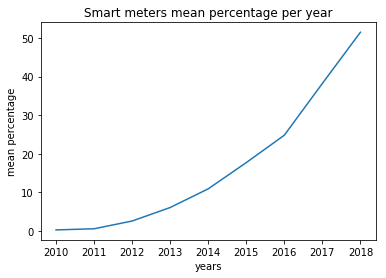

In [11]:
years = ["2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018"]
smart_meters = []
for year in years:
    data = pd.read_csv("electricity/enexis_electricity_%s.csv" % year)
    smart_meters.append(np.mean(data["smartmeter_perc"]))
plt.plot(years, smart_meters)
ax = plt.gca()
ax.set_ylabel("mean percentage")
ax.set_xlabel("years")
ax.set_title("Smart meters mean percentage per year")
plt.show()

## DBSCAN model

In [12]:
years = ["2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018"]
raw_data = []
for year in years:
    raw_data.append(pd.read_csv("electricity/enexis_electricity_%s.csv" % year))

In [13]:
# find NA
for dataframe,year in zip(raw_data,years):
    for i in range(np.shape(dataframe)[1]):
        if(np.shape(dataframe.loc[dataframe.iloc[:,i].isna()])[0] > 0):
            print("%s: %d" % (year, i))

2017: 10
2018: 7


In [14]:
# drop NA
data = []
for dataframe in raw_data:
    dataframe = dataframe.dropna().reset_index(drop = True)

    # process data
    type_conn_perc_list = []
    for i in range(len(dataframe["type_conn_perc"])):
        s = dataframe.loc[i, "type_conn_perc"]
        if(isinstance(s, str)):
            s = s.replace(",", ".")
        type_conn_perc_list.append(float(s))
    dataframe["type_conn_perc"] = type_conn_perc_list
    data.append(dataframe)

In [15]:
data[0].head()

,net_manager,purchase_area,street,zipcode_from,zipcode_to,city,delivery_perc,num_connections,perc_of_active_connections,type_conn_perc,type_of_connection,annual_consume,annual_consume_lowtarif_perc,smartmeter_perc
0,Enexis B.V.,ENEXIS,Sasdijk,4251AB,4251AB,WERKENDAM,100,16,100,71.91,1X25,4282,25,0.0
1,Enexis B.V.,ENEXIS,Sasdijk,4251AC,4251AC,WERKENDAM,100,11,100,71.75,1X25,5113,10,0.0
2,Enexis B.V.,ENEXIS,Sasdijk,4251AD,4251AD,WERKENDAM,100,30,100,70.37,3X25,4809,34,0.0
3,Enexis B.V.,ENEXIS,Nieuweweg,4251AE,4251AG,WERKENDAM,100,21,100,69.21,1X25,5015,44,0.0
4,Enexis B.V.,ENEXIS,Koppenhof,4251AH,4251AH,WERKENDAM,100,12,100,74.11,1X25,3074,22,0.0


In [16]:
dbscan_data_list = []
for dataframe in data:
    dbscan_data = pd.DataFrame(dataframe.iloc[:, [6,9,11,12,13]]).reset_index(drop = True)
    dbscan_data["active_connections"] = dataframe["num_connections"] * dataframe["perc_of_active_connections"] / 100
    dbscan_data = StandardScaler().fit_transform(dbscan_data)
    dbscan_data_list.append(dbscan_data)

In [17]:
%%time
predict_list = []
for dataframe, year in zip(dbscan_data_list, years):
    predict = DBSCAN(eps = 0.4, min_samples = 5, n_jobs = 8).fit_predict(dataframe)
    predict_list.append(predict)
    print(year)

2010
2011
2012
2013
2014
2015
2016
2017
2018
Wall time: 5min 16s


In [18]:
for predict in predict_list:
    print("cluster: %d" % len(set(predict)))
    print("outliners: %d" % predict.tolist().count(-1))
    print("larger than 0: %d" % (np.count_nonzero(predict) - predict.tolist().count(-1)))
    print("total data: %d" % len(predict))
    print("========================================")

cluster: 46
outliners: 1585
larger than 0: 1074
total data: 105650
cluster: 79
outliners: 5468
larger than 0: 4659
total data: 108299
cluster: 172
outliners: 9586
larger than 0: 2397
total data: 109808
cluster: 210
outliners: 15007
larger than 0: 12225
total data: 113248
cluster: 224
outliners: 18249
larger than 0: 22196
total data: 113644
cluster: 213
outliners: 19651
larger than 0: 1507
total data: 113989
cluster: 225
outliners: 20528
larger than 0: 1373
total data: 110577
cluster: 223
outliners: 20750
larger than 0: 1371
total data: 115507
cluster: 110
outliners: 8468
larger than 0: 735
total data: 123986
